# Imports

In [73]:
import matplotlib.pyplot as plt
import torch
import random  
import numpy as np
import json
from sklearn.model_selection import train_test_split
import torch
import cv2

# Code

Set the paths and import the label array

In [74]:
# Define the path to the folder containing the images and labels
path = "../../Datasets/Real life data/"

# Load the labels from the tensor file
labels = torch.load(path+'y_real_life.pt')

print("Labels loaded")
print("Number of images: ", len(labels))

Labels loaded
Number of images:  32000


We now plot the distribution of the real life data. We save the class distirbutions in a JSON file to be able to easily plot them later if necessary. We expect a lot of empty squares in the data.

In [75]:
# Define the class_names dictionary
class_names = {
    0: 'Empty', 1: 'White pawn', 2: 'White knight', 3: 'White bishop', 4: 'White rook',
    5: 'White queen', 6: 'White king', 7: 'Black pawn', 8: 'Black knight', 9: 'Black bishop',
    10: 'Black rook', 11: 'Black queen', 12: 'Black king'
}

# Compute the class distribution
class_distribution_dict = {}
class_distributions = {}
for label in sorted(labels):
    class_name = class_names[label.item()]
    class_distributions[class_name] = class_distributions.get(class_name, 0) + 1
class_distribution_dict["full"] = class_distributions

# Save the class distribution to a JSON file
json_file = "class_distribution.json"
with open(json_file, 'w') as f:
    json.dump(class_distribution_dict, f)

print("Class distribution saved to", json_file)
print(class_distribution_dict)

Class distribution saved to class_distribution.json
{'full': {'Empty': 22445, 'White pawn': 2452, 'White knight': 489, 'White bishop': 586, 'White rook': 641, 'White queen': 291, 'White king': 500, 'Black pawn': 2103, 'Black knight': 401, 'Black bishop': 653, 'Black rook': 609, 'Black queen': 330, 'Black king': 500}}


We now use the computed class distribution and plot them on a histogram. We can see that the data is very unbalanced. We will now remove empty squares from the training set to rebalance the data.

In [76]:
def plot_class_distribution(class_distribution, save=True):
    # Extract class names and frequencies from the JSON data
    class_names = list(class_distribution.keys())
    frequencies = list(class_distribution.values())

    # Calculate the total count
    total_count = sum(frequencies)

    # Calculate the percentage for each frequency
    percentages = [count / total_count * 100 for count in frequencies]

    # Create a bar plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(class_names, frequencies)
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.title("Class Distribution")
    plt.xticks(rotation=90)

    # Add the percentage labels to the bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f"{percentages[i]:.2f}%", ha='center', va='bottom')

    # Display & save the plot
    plt.tight_layout()
    if save:
        plt.savefig("../../Resources/Pre-processing/target_domain_distribution.jpg")

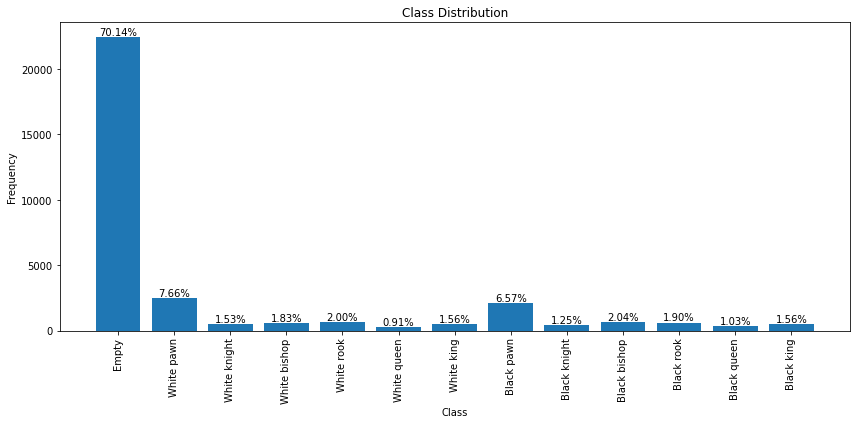

In [77]:
# Load the class ditribution from the JSON file
with open("class_distribution.json", "r") as f:
    class_distribution = json.load(f)
    
plot_class_distribution(class_distribution["full"])

Based on the histogram, it is evident that empty squares make up the majority, comprising about 70% of the images. Moreover, and as expected, pawns have the highest proportion among the chess pieces (around 13% in total). Additionally, the proportion of white and black pieces is similar for each piece. For instance, the proportion of the white queen is 0.91%, while that of the black queen is 1.03%.

In this context, the imbalance in the data due to the abundance of empty squares may cause the model to have a bias towards identifying empty squares rather than chess pieces. To mitigate this issue, a pre-processing step is suggested, which involves creating a sampler when loading the data which takes into account the class propotions. This helps to improve the focus of the model on recognizing chess pieces rather than empty squares, which may not contain any useful information for the classification task. Additionally, too many empty squares may hinder domain adaptation since empty squares are similar across both domains. Furthermore, since empty squares are easy to recognize, their over-representation may lead the model to overfit to empty squares rather than the task of identifying chess pieces. This step is implemented in the Custom_Dataset.py file in the Datasets folder.

# Saving the full Real Life Dataset splitted into train, validation and test sets

We first split the full real life dataset into train, validation and test sets. We keep all images in the same folder and we create three JSON files (one for each set) that contain the paths to the images in each set. Each JSON file has the name of the images as keys and the corresponding label as values. We save the JSON files in "Datasets/Real Life Data".

In [78]:
# Set the seed for reproducibility
np.random.seed(50)

# Number of images
num_images = labels.shape[0]

# Generate indices for shuffling
square_indices = np.arange(num_images)

# Extract 5 positions from the dataset and assume they were manually labelled (ie the labels are available for those)
# Because, in this case, real data is assumed to unlabelled, our validation set consists of 5 positions labelled manually
# This amounts to 5 * 64 = 320 images of individual squares, which is a reasonable amount of positions to ask a user to label manually
# This is done just for the purposes of having a dataset to perform hyperparameter tuning on
# Because we would like positions where squares are mostly full, we query the dataset and only sample images with at least 28 pieces on the board

# Extract 5 positions with more than 28 pieces on the board, shuffling the positions first to ensure none are from the same game
# This leads to different lighting brightnesses and angles for each position
val_positions_indices = [] 
position_indices = np.random.permutation(num_images // 64)
for position_index in position_indices:
    # A label of 0 corresponds to an empty square
    if (labels[position_index*64:(position_index+1)*64] != 0).sum() >= 28:
        val_positions_indices.append(position_index)
        if len(val_positions_indices) == 5:
            break
        
if len(val_positions_indices) < 5:
    raise Exception("Not enough positions with at least 28 pieces on the board")

# Extract the indices of the square images corresponding to the 5 positions and remove them from the square index array
val_indices = []
for val_position_index in val_positions_indices:
    val_indices.extend(square_indices[val_position_index*64:(val_position_index+1)*64])

# Delete the indices of the square images corresponding to the 5 positions from the square index array IN REVERSE ORDER
# This is done in reverse order to ensure that deleting previous indices does not affect subsequent indices
for val_position_index in sorted(val_positions_indices, reverse=True):
    square_indices = np.delete(square_indices, np.s_[val_position_index*64:(val_position_index+1)*64])

# Split the indices into training and testing sets (90% and 10% respectively)
train_indices, test_indices = train_test_split(square_indices, test_size=0.1, random_state=50, shuffle=True)

# Create dictionaries to store the image names for each set
train_set = {"train": [], "label": []}
val_set = {"validation": [], "label": []}
test_set = {"test": [], "label": []}

# Iterate over the indices and assign image names to the corresponding sets
for index in train_indices:
    image_name = f"EX_{str(index).zfill(6)}.png"
    train_set["train"].append(image_name)
    train_set["label"].append(labels[index].item())

for index in val_indices:
    image_name = f"EX_{str(index).zfill(6)}.png"
    val_set["validation"].append(image_name)
    val_set["label"].append(labels[index].item())

for index in test_indices:
    image_name = f"EX_{str(index).zfill(6)}.png"
    test_set["test"].append(image_name)
    test_set["label"].append(labels[index].item())

# Save the sets as JSON files
with open(path+"train_full_real_life_data.json", "w") as train_file:
    json.dump(train_set, train_file)

with open(path+"validation_full_real_life_data.json", "w") as val_file:
    json.dump(val_set, val_file)

with open(path+"test_full_real_life_data.json", "w") as test_file:
    json.dump(test_set, test_file)

# Print the size of each set
print("Training set size:", len(train_set["train"]))
print("Validation set size:", len(val_set["validation"]))
print("Testing set size:", len(test_set["test"]))

Training set size: 28512
Validation set size: 320
Testing set size: 3168


Re-compute the class distributions in each of the train, validation, and test sets.

In [79]:
json_file = "class_distribution.json"

def sort_and_return(list):
    list.sort()
    return list

# Extract the frequency of each class
class_distributions_train = {}
for label in sort_and_return(train_set["label"]):
    class_name = class_names[label]
    class_distributions_train[class_name] = class_distributions_train.get(class_name, 0) + 1
class_distribution_dict["train"] = class_distributions_train

class_distributions_val = {}
for label in sort_and_return(val_set["label"]):
    class_name = class_names[label]
    class_distributions_val[class_name] = class_distributions_val.get(class_name, 0) + 1
class_distribution_dict["validation"] = class_distributions_val

class_distributions_test = {}
for label in sort_and_return(test_set["label"]):
    class_name = class_names[label]
    class_distributions_test[class_name] = class_distributions_test.get(class_name, 0) + 1
class_distribution_dict["test"] = class_distributions_test

# Overwrite the distribution json file
with open(json_file, 'w') as f:
    f.seek(0)
    json.dump(class_distribution_dict, f)

# Sanity check
print(class_distribution_dict)

{'full': {'Empty': 22445, 'White pawn': 2452, 'White knight': 489, 'White bishop': 586, 'White rook': 641, 'White queen': 291, 'White king': 500, 'Black pawn': 2103, 'Black knight': 401, 'Black bishop': 653, 'Black rook': 609, 'Black queen': 330, 'Black king': 500}, 'train': {'Empty': 20037, 'White pawn': 2166, 'White knight': 426, 'White bishop': 530, 'White rook': 572, 'White queen': 253, 'White king': 443, 'Black pawn': 1873, 'Black knight': 348, 'Black bishop': 581, 'Black rook': 540, 'Black queen': 297, 'Black king': 446}, 'validation': {'Empty': 165, 'White pawn': 38, 'White knight': 10, 'White bishop': 10, 'White rook': 10, 'White queen': 5, 'White king': 5, 'Black pawn': 37, 'Black knight': 10, 'Black bishop': 10, 'Black rook': 10, 'Black queen': 5, 'Black king': 5}, 'test': {'Empty': 2243, 'White pawn': 248, 'White knight': 53, 'White bishop': 46, 'White rook': 59, 'White queen': 33, 'White king': 52, 'Black pawn': 193, 'Black knight': 43, 'Black bishop': 62, 'Black rook': 59,

We can now visualize the validation set's distribution to ensure that we got a good proportion of each piece type.

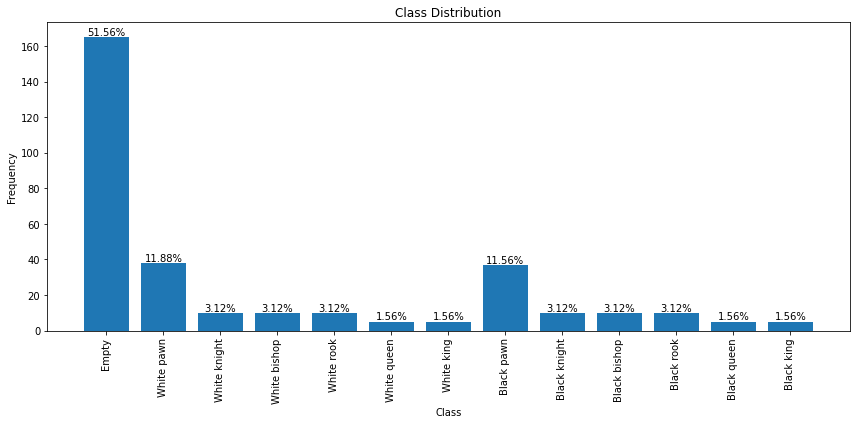

In [80]:
# Load the class ditribution from the JSON file
with open("class_distribution.json", "r") as f:
    class_distribution = json.load(f)

plot_class_distribution(class_distribution["validation"], save=False)